# Predict Energy cosumption in Bangalore 
-- data from 1 March 2024 - till today

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error

In [2]:
database_config = {
    'host': 'pulse-central-pgdb-prod-read-replica.cusfwzqs1vx0.ap-south-1.rds.amazonaws.com',
    'port': '5432',
    'database': 'pulse_central_db',
    'user': 'rajshri_ta_da',
    'password': 'KJNK=KCJNEOJ21809E81209-J0NPIBDUOH8P923190E-10-9'
}

In [58]:
# extracting data from PostgreSQL database by connecting the database here
import psycopg2
from psycopg2 import sql

# Connect to your PostgreSQL database
conn = psycopg2.connect(
        host = database_config['host'],
        port = database_config['port'],
        database = database_config['database'],
        user = database_config['user'],
        password = database_config['password']
)

# Create a cursor object
cursor = conn.cursor()

# Define the query
query = sql.SQL("""
SELECT
    vo.vehicle_number_plate AS car_number,
    ct.created_on AT TIME ZONE 'utc' AT TIME ZONE 'asia/kolkata' AS created_on,
    ct.energy_delivered as energy_delivered
    FROM
    charge_transaction ct
    LEFT JOIN vehicle_owner vo ON vo.id = ct.vehicle_owner_id
WHERE
    date(ct.created_on AT TIME ZONE 'utc' AT TIME ZONE 'asia/kolkata') >= '2024-01-01'
    and ct.energy_delivered is not null
    and vo.vehicle_number_plate in (select distinct external_data_id from external_data where source_id = '50'
                                        and external_data_id like 'KA%')
""")

# Execute the query
cursor.execute(query)
# Fetch all the results into a DataFrame
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(cursor.fetchall(), columns=column_names)

# Close the cursor and connection
cursor.close()
conn.close()

In [59]:
df.shape

(58590, 3)

# data cleaing and processing

In [60]:
df1 = df.copy(deep = True)

In [61]:
df1['energy_delivered'] = df1['energy_delivered'].astype(float)

# new features

In [62]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58590 entries, 0 to 58589
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   car_number        58590 non-null  object        
 1   created_on        58590 non-null  datetime64[ns]
 2   energy_delivered  58590 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.3+ MB


In [63]:
df1['created_on'] = pd.to_datetime(df1['created_on'])

In [64]:
df1['date'] = df1['created_on'].dt.date
df1['weekday'] = df1['created_on'].dt.day_name()
df1['week_number'] = df1['created_on'].dt.day // 7 + 1

In [65]:
df1.head()

,car_number,created_on,energy_delivered,date,weekday,week_number
0,KA03AK7582,2024-01-11 02:03:27.804,0.0,2024-01-11,Thursday,2
1,KA03AK7487,2024-04-02 18:59:49.562,0.0,2024-04-02,Tuesday,1
2,KA03AK6755,2024-05-06 16:23:00.016,0.0,2024-05-06,Monday,1
3,KA03AL2826,2024-02-05 19:12:14.794,0.0,2024-02-05,Monday,1
4,KA03AL8531,2024-02-27 06:22:38.845,0.0,2024-02-27,Tuesday,4


In [66]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58590 entries, 0 to 58589
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   car_number        58590 non-null  object        
 1   created_on        58590 non-null  datetime64[ns]
 2   energy_delivered  58590 non-null  float64       
 3   date              58590 non-null  object        
 4   weekday           58590 non-null  object        
 5   week_number       58590 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 2.5+ MB


In [67]:
df1['week_number'] = df1['week_number'].astype('object')
df1['date'] = pd.to_datetime(df1['date'])

# outliers (if any)

In [68]:
df1['energy_delivered'].describe()

count    58590.000000
mean         7.145212
std          8.966974
min          0.000000
25%          0.000000
50%          1.620000
75%         14.100000
max        498.170000
Name: energy_delivered, dtype: float64

In [69]:
#drop rows where energy_delivered is negative
df1 = df1[df1['energy_delivered']>0]

In [70]:
df1.shape

(32456, 6)

In [71]:
df2 = df1.copy(deep =True)

In [72]:
df2 = df2[['car_number','created_on','date', 'weekday', 'week_number', 'energy_delivered']]

In [73]:
df2 = df2.groupby(['date'], as_index = False).agg({'car_number': 'nunique' ,'weekday': 'first', 'week_number':'first', 
                                             'energy_delivered': 'sum' })
df2.rename(columns={'car_number': 'no_of_cars'}, inplace = True)
df2

,date,no_of_cars,weekday,week_number,energy_delivered
0,2024-01-01,54,Monday,1,949.660
1,2024-01-02,69,Tuesday,1,1206.680
2,2024-01-03,88,Wednesday,1,1375.889
3,2024-01-04,100,Thursday,1,1655.551
4,2024-01-05,108,Friday,1,1963.033
...,...,...,...,...,...
125,2024-05-05,111,Sunday,1,3395.261
126,2024-05-06,136,Monday,1,2556.948
127,2024-05-07,134,Tuesday,2,3280.830
128,2024-05-08,117,Wednesday,2,2541.216


# visualizing data

<Axes: xlabel='energy_delivered', ylabel='Density'>

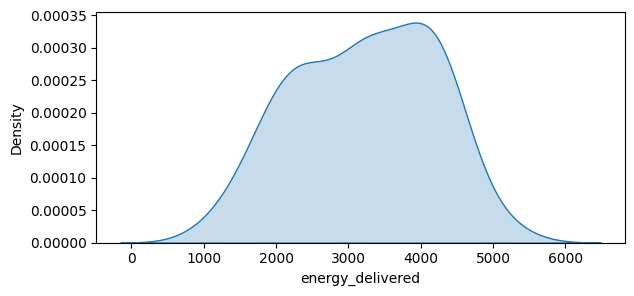

In [74]:
#distplot for gre score and toefl score
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.kdeplot(df2["energy_delivered"], shade = True)

# data preparation

In [75]:
df3 = df2.copy(deep = True)

In [76]:
df4 = df3[['no_of_cars', 'weekday','week_number','energy_delivered']]
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   no_of_cars        130 non-null    int64  
 1   weekday           130 non-null    object 
 2   week_number       130 non-null    object 
 3   energy_delivered  130 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ KB


In [77]:
# split into X and y
X = df4.loc[:,['no_of_cars', 'weekday', 'week_number']]
y = df4["energy_delivered"]
X.head()

,no_of_cars,weekday,week_number
0,54,Monday,1
1,69,Tuesday,1
2,88,Wednesday,1
3,100,Thursday,1
4,108,Friday,1


In [78]:
X.shape

(130, 3)

In [79]:
# creating dummy variables for categorical variables
# subset all categorical variables
X_cat = X.select_dtypes(include=["object"])
X_num = X.select_dtypes(include=["int64","float64"])
print(X_cat.head())
print(X_num.head())

     weekday week_number
0     Monday           1
1    Tuesday           1
2  Wednesday           1
3   Thursday           1
4     Friday           1
   no_of_cars
0          54
1          69
2          88
3         100
4         108


In [80]:
# convert into dummies
X_dummies = pd.get_dummies(X_cat,drop_first = True)

# drop categorical variables from X data
X = X.drop(list(X_cat.columns),axis = 1)

# concat dummy variables with X
X = pd.concat([X,X_dummies],axis = 1)

In [81]:
X.head()

,no_of_cars,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,week_number_2,week_number_3,week_number_4,week_number_5
0,54,True,False,False,False,False,False,False,False,False,False
1,69,False,False,False,False,True,False,False,False,False,False
2,88,False,False,False,False,False,True,False,False,False,False
3,100,False,False,False,True,False,False,False,False,False,False
4,108,False,False,False,False,False,False,False,False,False,False


In [82]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   no_of_cars         130 non-null    int64
 1   weekday_Monday     130 non-null    bool 
 2   weekday_Saturday   130 non-null    bool 
 3   weekday_Sunday     130 non-null    bool 
 4   weekday_Thursday   130 non-null    bool 
 5   weekday_Tuesday    130 non-null    bool 
 6   weekday_Wednesday  130 non-null    bool 
 7   week_number_2      130 non-null    bool 
 8   week_number_3      130 non-null    bool 
 9   week_number_4      130 non-null    bool 
 10  week_number_5      130 non-null    bool 
dtypes: bool(10), int64(1)
memory usage: 2.4 KB


In [83]:
# split into train and test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [84]:
#check the same of test and train data
print(X_scaled.shape)
print(y.shape)

(130, 11)
(130,)


# building model using Liner Regression

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Instantiate the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_scaled, y)

LinearRegression()

In [86]:
w1 = model.coef_
w0 = model.intercept_
print(w1,w0)

[847.48833481 -68.82193369  -7.37944979  24.60775975 -19.22176327
 -48.19110139 -15.57546203  13.42569417  29.58068609  39.19142109
   2.15188507] 3220.2921461538463


In [87]:
#calculate the y_pred from the model you created
y_pred = model.predict(X_scaled)

In [88]:
#Evalution for Train Data
r2 = r2_score(y,y_pred)
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt( mean_squared_error(y,y_pred))
mape = mean_absolute_percentage_error(y,y_pred)

# initialise data of lists.
perf_data = [[r2],[mae],[mse],[rmse],[mape]]

# Creates pandas DataFrame.
eval_train = pd.DataFrame(perf_data,columns= ["Scores"] ,index = ["R-Squared","Mean Absolute Error","Mean Square Error",
                                                             "Root Mean Square Error","Mean Absolute Percentage Error"])
eval_train

,Scores
R-Squared,0.786129
Mean Absolute Error,348.711577
Mean Square Error,201188.394677
Root Mean Square Error,448.540293
Mean Absolute Percentage Error,0.120319


In [89]:
y_pred = y_pred.tolist()

In [90]:
y = y.tolist()

In [91]:
df_results = pd.DataFrame({'y': y, 'y_pred': y_pred})

In [92]:
df_results

,y,y_pred
0,949.660,835.545983
1,1206.680,1203.334181
2,1375.889,1687.551846
3,1655.551,1924.739588
4,1963.033,2144.158434
...,...,...
125,3395.261,2277.283421
126,2556.948,2526.861540
127,3280.830,2575.516304
128,2541.216,2317.205188


# Trying other models

In [93]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [94]:
# Building Pipeline
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    # 'LGBMRegressor': LGBMRegressor(verbose=-1),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}

params = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1]},
    'ElasticNet': {'model__alpha': [0.001, 0.01, 0.1], 'model__l1_ratio': [0.2, 0.5, 0.8]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__epsilon': [0.1, 0.2, 0.5], 'model__kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100]},
    'XGBRegressor': {'model__learning_rate': [0.1, 0.5], 'model__max_depth': [3, 5, 7]},
    # 'LGBMRegressor': {'model__learning_rate': [0.1, 0.5], 'model__num_leaves': [31, 50, 100]},
    'CatBoostRegressor': {'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [4, 6, 8]}
}

results = []

In [95]:
from sklearn.metrics import mean_squared_error, make_scorer

# Define the RMSE function
def rmse(y, y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [96]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
import math

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('model', model)
    ])
    if name in params:
        grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring=rmse_scorer)
    else:
        grid_search = GridSearchCV(pipeline, {}, cv=5, scoring=rmse_scorer)
        
    grid_search.fit(X_scaled, y)
    y_pred = grid_search.predict(X_scaled)
    r2 = grid_search.best_estimator_.score(X_scaled, y)
    rmse_val = rmse(y, y_pred)
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_val = mean_absolute_percentage_error(y, y_pred) * 100
    
    results.append({
        'Model': name,
        'R-Squared Score': r2,
        'RMSE Score': rmse_val,
        'MAPE Score': mape_val,  # Add MAPE to results
        'Best Parameters': str(grid_search.best_params_)  # Convert dictionary to string
    })

results_df = pd.DataFrame(results)

# Set display options to show full width of the DataFrame
pd.set_option('display.max_colwidth', None)

In [97]:
results_df

,Model,R-Squared Score,RMSE Score,MAPE Score,Best Parameters
0,LinearRegression,0.786129,448.540293,12.031862,{}
1,Ridge,0.786129,448.540785,12.031563,{'model__alpha': 0.1}
2,Lasso,0.786129,448.540685,12.029464,{'model__alpha': 0.1}
3,ElasticNet,0.786129,448.540327,12.031765,"{'model__alpha': 0.001, 'model__l1_ratio': 0.8}"
4,SVR,0.706561,525.392847,16.390917,"{'model__C': 10, 'model__epsilon': 0.1, 'model__kernel': 'linear'}"
5,RandomForestRegressor,0.948695,219.688428,5.532511,{'model__n_estimators': 100}
6,XGBRegressor,0.903554,301.209087,7.746334,"{'model__learning_rate': 0.1, 'model__max_depth': 3}"
7,CatBoostRegressor,0.871038,348.301733,8.994234,"{'model__depth': 4, 'model__learning_rate': 0.01}"


In [104]:
rfr = RandomForestRegressor(n_estimators= 100)
rfr.fit(X_scaled, y)

RandomForestRegressor()

In [105]:
y_pred_rfr = rfr.predict(X_scaled)

In [106]:
#Evalution for Train Data
r2 = r2_score(y,y_pred_rfr)
mae = mean_absolute_error(y,y_pred_rfr)
mse = mean_squared_error(y,y_pred_rfr)
rmse = np.sqrt( mean_squared_error(y,y_pred_rfr))
mape = mean_absolute_percentage_error(y,y_pred_rfr)

# initialise data of lists.
perf_data = [[r2],[mae],[mse],[rmse],[mape]]

# Creates pandas DataFrame.
eval_train = pd.DataFrame(perf_data,columns= ["Scores"] ,index = ["R-Squared","Mean Absolute Error","Mean Square Error",
                                                             "Root Mean Square Error","Mean Absolute Percentage Error"])
eval_train

,Scores
R-Squared,0.948945
Mean Absolute Error,164.105687
Mean Square Error,48027.744336
Root Mean Square Error,219.152331
Mean Absolute Percentage Error,0.055833


In [109]:
fit_model = rfr.fit(X_scaled, y)

In [111]:
import pickle

# Assuming fit_model is your trained RandomForestRegressor object
with open('rfr_model.pkl', 'wb') as f:
    pickle.dump(fit_model, f)

In [54]:
y_pred_xgbr = y_pred_xgbr.tolist()
df_results_xgbr = pd.DataFrame({'y': y, 'y_pred': y_pred_rfr})

In [55]:
df3_prediction = pd.concat([df3, df_results_xgbr], axis=1)

In [107]:
import joblib

# Save the model to a file
joblib.dump(rfr, 'energy_consumption_prediction_model.pkl')

['energy_consumption_prediction_model.pkl']

In [108]:
### Create a Pickle file using serialization 
import pickle
pickle_out = open("energy_consumption_prediction_model.pkl","wb")
pickle.dump(rfr, pickle_out)
pickle_out.close()

In [56]:
df3_prediction.drop(columns = ['weekday', 'week_number', 'y'], inplace = True)

In [ ]:
df3_prediction.to_excel('XGBoost_prediction.xlsx')

# New data prediction

In [ ]:
input_data = pd.read_excel('input data.xlsx')

In [ ]:
input_data['weekday'] = input_data['date'].dt.day_name()
input_data['week_number'] = input_data['date'].dt.day // 7 + 1

In [ ]:
input_data['week_number'] = input_data['week_number'].astype('object')

In [ ]:
input_data.info()

### processing data

In [ ]:
X = input_data.loc[:,['no_of_cars', 'weekday', 'week_number']]

In [ ]:
# subset all categorical variables
X_cat = X.select_dtypes(include=["object"])
X_num = X.select_dtypes(include=["int64","float64"])

In [ ]:
# convert into dummies
X_dummies = pd.get_dummies(X_cat,drop_first = True)

# drop categorical variables from X data
X = X.drop(list(X_cat.columns),axis = 1)

# concat dummy variables with X
X = pd.concat([X,X_dummies],axis = 1)

In [ ]:
# split into train and test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
y_pred_xgbr = xgbr.predict(X_scaled)

In [ ]:
predicted_consumption_values = np.array(y_pred_xgbr)

In [ ]:
input_data['predicted_consumption'] = predicted_consumption_values

In [ ]:
input_data.drop(columns=['weekday', 'week_number'], inplace=True)

In [ ]:
# input_data.to_excel('input_data_prediction.xlsx')